# Test 3: "Real-world" waveform with noise

Just like with the sinusoid test, we can use audio recordings of real-world sounds as a basis for testing the system performance on more complex waveforms, and add progressive levels of white noise for each iteration. 

In the "Data" folder you can find a number of audio files you can use as test input. Most of these files contain a short recording of a continuous musical note. If you wish to adjust the samping frequency of the sound files, take a look at the function [`resample`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.resample.html) in the `scipy.signal` module.

Create a python program which lads a specific audio file and adds progressively increasing levels of white gaussian noise before feeding it into the attached function `freq_detection`. Subsequently, your program should provide an analysis of the outuput from the function `freq_detection` for the various noise levels, which can take the form of a plot showing the frequency detection system's error as a function of SNR. This will be useful when evaluating the frequency detection system's performance in the presence of noise. Measuring the frequency estimate error in such a way will allow us to evaluate two things:

1. How well the frequency detection system can estimate the fundamental frequency of a "real-world" periodic waveform
2. The effect of white noise interference on the frequency detection system when applied to a "real-world" periodic waveform

P.S. You can determine appropriate noise power(s) by calculating the average power in the audio clip as a basis for and scaling by desired SNR

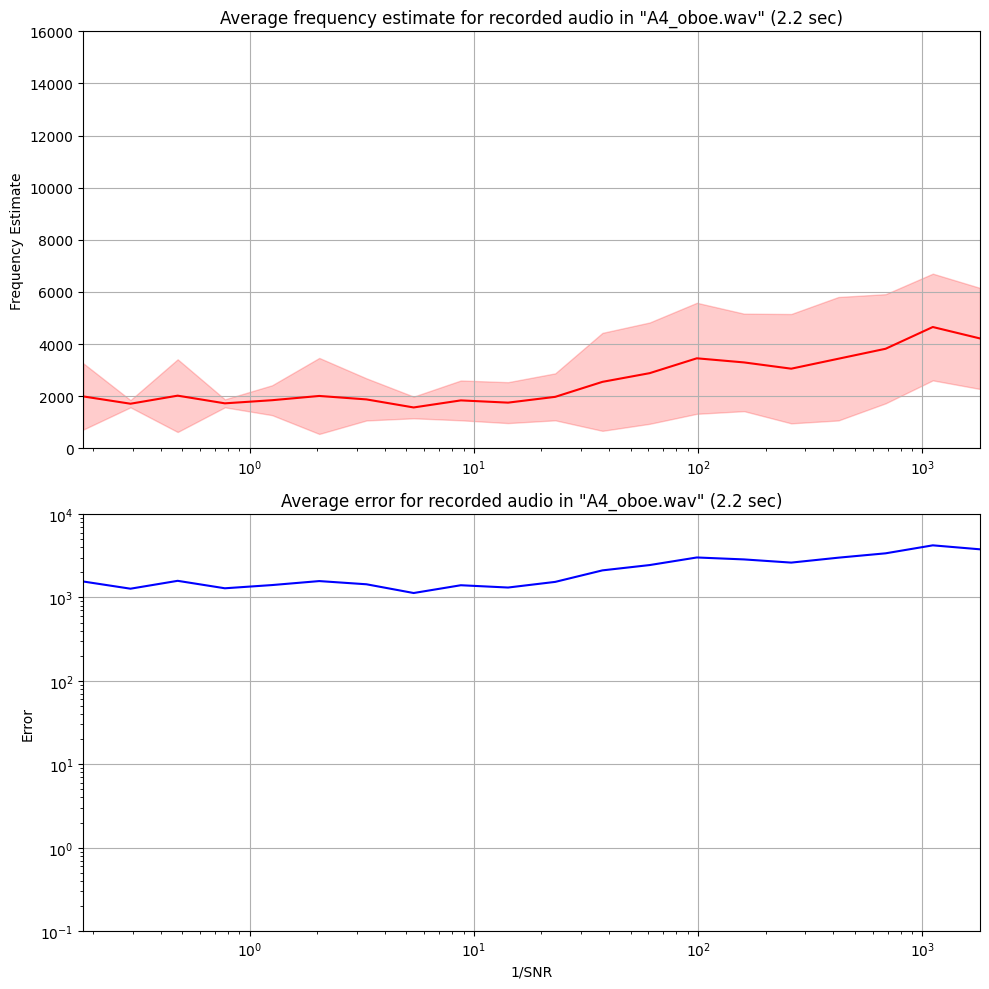

In [12]:
from baseline_algorithm import freq_detection
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import resample_poly
# WRITE YOUR CODE IN THIS CELL:

fsOriginal, audioSignal = wavfile.read('sample_audio/A4_oboe.wav')
audioSignal = audioSignal.astype(np.float32) / np.max(np.abs(audioSignal))

if audioSignal.ndim > 1:
    audioSignal = audioSignal[:, 0]

fs_target = 16_000
duration = 2.2
N_samples = int(duration * fs_target)
audioSignalResampled = resample_poly(audioSignal, fs_target, fsOriginal) if fsOriginal != fs_target else audioSignal

audioSignalResampled = np.pad(audioSignalResampled[:N_samples], (0, max(0, N_samples - len(audioSignalResampled))), 'constant')

signalPwr = np.mean(audioSignalResampled ** 2)

noisePwr = np.logspace(-2, 2, 20)

avgEst = []
avgErrros = []
var = []
SNRs = []

trueFrequency = 440
N_DFT = 2048

for noiseVar in noisePwr:
    noise = np.random.normal(scale=np.sqrt(noiseVar), size=len(audioSignalResampled))
    noisySignal = audioSignalResampled + noise
    _, f_est = freq_detection(noisySignal, fs_target, N=N_DFT)
    f_est = np.clip(f_est, 0, fs_target / 2)

    avg_est_freq = np.mean(f_est)
    variance = np.var(f_est)
    error = np.abs(avg_est_freq - trueFrequency)

    snr = signalPwr / noiseVar
    SNRs.append(snr)

    avgEst.append(avg_est_freq)
    avgErrros.append(error)
    var.append(variance)

inv_SNRs = 1 / np.array(SNRs)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10))

ax1.plot(inv_SNRs, avgEst, color='r')
ax1.fill_between(inv_SNRs, np.array(avgEst) - np.sqrt(var),
                 np.array(avgEst) + np.sqrt(var), color='red', alpha=0.2)
ax1.set_xscale('log')
ax1.set_xlim([inv_SNRs.min(), inv_SNRs.max()])
ax1.set_ylim([0, 16000])
ax1.set_title('Average frequency estimate for recorded audio in "A4_oboe.wav" (2.2 sec)')
ax1.set_ylabel('Frequency Estimate')
ax1.grid(True)

ax2.plot(inv_SNRs, avgErrros, color='b')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim([inv_SNRs.min(), inv_SNRs.max()])
ax2.set_ylim([1e-1, 1e4])
ax2.set_title('Average error for recorded audio in "A4_oboe.wav" (2.2 sec)')
ax2.set_xlabel('1/SNR')
ax2.set_ylabel('Error')
ax2.grid(True)

plt.tight_layout()
plt.show()

[Here](Figures/wavfileTest_LF.png) is an image showing a *suggestion* for what or test output may look like when using the audio in `A4_oboe.wav` as a signal. As we can see, the frequency detection system produces a stable but erroneous output when there is little noise, suggesting it has "locked on" to a harmonic rather than the fundamental frequency. It is also interesting to note that the noise will begin to cause the estimated frequency to fluctuate a lot earlier than in the case with the pure sinusoid, so while the average error remains more or less unchanged, the estimated frequency will vary significantly.